![](http://spark.apache.org/images/spark-logo.png) ![](https://upload.wikimedia.org/wikipedia/commons/f/f8/Python_logo_and_wordmark.svg)

In [1]:
%autosave 10

Autosaving every 10 seconds


# MLlib: Basic Statistics and Exploratory Data Analysis
[MLlib](https://spark.apache.org/docs/latest/mllib-guide.html) is Spark's machine learning library.

In [2]:
# Import Packages
import numpy as np
from pyspark.mllib.stat import Statistics 
from math import sqrt 


In [3]:
# Getting the data and creating the RDD
data_file = "./kddcup.data_10_percent.gz"
raw_data = sc.textFile(data_file)


# Local vectors
A [local vector](https://spark.apache.org/docs/latest/mllib-data-types.html#local-vector) is often used as a base type for RDDs in Spark MLlib. A local vector has integer-typed and 0-based indices and double-typed values, stored on a single machine. MLlib supports two types of local vectors: dense and sparse. A dense vector is backed by a double array representing its entry values, while a sparse vector is backed by two parallel arrays: indices and values.


For dense vectors, MLlib uses either Python lists or the NumPy array type. The later is recommended, so you can simply pass NumPy arrays around.


For sparse vectors, users can construct a SparseVector object from MLlib or pass SciPy scipy.sparse column vectors if SciPy is available in their environment. The easiest way to create sparse vectors is to use the factory methods implemented in Vectors.


# An RDD of dense vectors
Let's represent each network interaction in our dataset as a dense vector. For that we will use the NumPy array type.


In [4]:
def parse_interaction(line):
    line_split = line.split(",")
    # keep just numeric and logical values
    symbolic_indices = [1,2,3,41]
    clean_line_split = [item for i, item in enumerate(line_split)
                              if i not in symbolic_indices]
    return np.array([float(x) for x in clean_line_split])

In [5]:
vector_data = raw_data.map(parse_interaction)


# Summary statistics
Spark's MLlib provides column summary statistics for ```RDD[Vector]``` through the function ```colStats``` available in Statistics. The method returns an instance of [```MultivariateStatisticalSummary```](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.stat.MultivariateStatisticalSummary), which contains the column-wise max, min, mean, variance, and number of nonzeros, as well as the total count.

In [6]:
# Compute column summary statistics.
summary = Statistics.colStats(vector_data)

In [7]:
print "Duration Statistics:"
print " Mean: {}".format(round(summary.mean()[0],3))
print " St. deviation: {}".format(round(sqrt(summary.variance()[0]),3))
print " Max value: {}".format(round(summary.max()[0],3))
print " Min value: {}".format(round(summary.min()[0],3))
print " Total value count: {}".format(summary.count())
print " Number of non-zero values: {}".format(summary.numNonzeros()[0])

Duration Statistics:
 Mean: 47.979
 St. deviation: 707.746
 Max value: 58329.0
 Min value: 0.0
 Total value count: 494021
 Number of non-zero values: 12350.0


# Summary statistics by label

The interesting part of summary statistics, in our case, comes from being able to obtain them by the type of network attack or 'label' in our dataset. By doing so we will be able to better characterise our dataset dependent variable in terms of the independent variables range of values.


If we want to do such a thing we could filter our RDD containing labels as keys and vectors as values. For that we just need to adapt our parse_interaction function to return a tuple with both elements.

In [8]:
def parse_interaction_with_key(line):
    line_split = line.split(",")
    # keep just numeric and logical values
    symbolic_indices = [1,2,3,41]
    clean_line_split = [item for i, item in enumerate(line_split)
                              if i not in symbolic_indices]
    return (line_split[41], np.array([float(x) for x in clean_line_split]))

In [9]:
label_vector_data = raw_data.map(parse_interaction_with_key)

The next step is not very sophisticated. We use filter on the RDD to leave out other labels but the one we want to gather statistics from.

In [10]:
normal_label_data = label_vector_data.filter(lambda x: x[0]=="normal.")


Now we can use the new RDD to call ```colStats``` on the values.

In [11]:
normal_summary = Statistics.colStats(normal_label_data.values())

In [12]:
print "Duration Statistics for label: {}".format("normal")
print " Mean: {}".format(normal_summary.mean()[0],3)
print " St. deviation: {}".format(round(sqrt(normal_summary.variance()[0]),3))
print " Max value: {}".format(round(normal_summary.max()[0],3))
print " Min value: {}".format(round(normal_summary.min()[0],3))
print " Total value count: {}".format(normal_summary.count())
print " Number of non-zero values: {}".format(normal_summary.numNonzeros()[0])

Duration Statistics for label: normal
 Mean: 216.657322313
 St. deviation: 1359.213
 Max value: 58329.0
 Min value: 0.0
 Total value count: 97278
 Number of non-zero values: 11690.0


Instead of working with a key/value pair we could have just filter our raw data split using the label in column 41. Then we can parse the results as we did before. This will work as well. However having our data organised as key/value pairs will open the door to better manipulations. Since values() is a transformation on an RDD, and not an action, we don't perform any computation until we call colStats anyway.

But lets wrap this within a function so we can reuse it with any label.

In [13]:
def summary_by_label(raw_data, label):
    label_vector_data = raw_data.map(parse_interaction_with_key).filter(lambda x: x[0]==label)
    return Statistics.colStats(label_vector_data.values())

In [14]:
normal_sum = summary_by_label(raw_data, "normal.")

print "Duration Statistics for label: {}".format("normal")
print " Mean: {}".format(normal_sum.mean()[0],3)
print " St. deviation: {}".format(round(sqrt(normal_sum.variance()[0]),3))
print " Max value: {}".format(round(normal_sum.max()[0],3))
print " Min value: {}".format(round(normal_sum.min()[0],3))
print " Total value count: {}".format(normal_sum.count())
print " Number of non-zero values: {}".format(normal_sum.numNonzeros()[0])

Duration Statistics for label: normal
 Mean: 216.657322313
 St. deviation: 1359.213
 Max value: 58329.0
 Min value: 0.0
 Total value count: 97278
 Number of non-zero values: 11690.0



Let's try now with some network attack. We have all of them listed [here](http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types).


In [15]:
def print_label_summary(labels):
    for label in labels:
        label_summary = summary_by_label(raw_data, label)
        print "Duration Statistics for label: {}".format(label)
        print " Mean: {}".format(label_summary.mean()[0],3)
        print " St. deviation: {}".format(round(sqrt(label_summary.variance()[0]),3))
        print " Max value: {}".format(round(label_summary.max()[0],3))
        print " Min value: {}".format(round(label_summary.min()[0],3))
        print " Total value count: {}".format(label_summary.count())
        print " Number of non-zero values: {}".format(label_summary.numNonzeros()[0])
        print "\n\n######################################################\n\n"        


In [16]:
labels = ["back.", "buffer_overflow."]
print_label_summary(labels)

Duration Statistics for label: back.
 Mean: 0.128915115751
 St. deviation: 1.11
 Max value: 14.0
 Min value: 0.0
 Total value count: 2203
 Number of non-zero values: 40.0


######################################################


Duration Statistics for label: buffer_overflow.
 Mean: 91.7
 St. deviation: 97.515
 Max value: 321.0
 Min value: 0.0
 Total value count: 30
 Number of non-zero values: 22.0


######################################################




We could build a table with duration statistics for each type of interaction in our dataset. First we need to get a list of labels as described in the first line [here](http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names).

In [17]:
label_list = ["back.","buffer_overflow.","ftp_write.","guess_passwd.",
              "imap.","ipsweep.","land.","loadmodule.","multihop.",
              "neptune.","nmap.","normal.","perl.","phf.","pod.","portsweep.",
              "rootkit.","satan.","smurf.","spy.","teardrop.","warezclient.",
              "warezmaster."]

Then we get a list of statistics for each label.

In [18]:
stats_by_label = [(label, summary_by_label(raw_data, label)) for label in label_list]

Now we get the duration column, first in our dataset (i.e. index 0).

In [19]:
duration_by_label = [ 
    (stat[0], np.array([float(stat[1].mean()[0]), float(sqrt(stat[1].variance()[0])), float(stat[1].min()[0]), float(stat[1].max()[0]), int(stat[1].count())])) 
    for stat in stats_by_label]

That we can put into a Pandas data frame.

In [20]:
import pandas as pd
pd.set_option('display.max_columns', 50)

stats_by_label_df = pd.DataFrame.from_items(duration_by_label, columns=["Mean", "Std Dev", "Min", "Max", "Count"], orient='index')

In [21]:
print "Duration statistics, by label"
stats_by_label_df

Duration statistics, by label


,Mean,Std Dev,Min,Max,Count
back.,0.128915,1.110062,0.0,14.0,2203.0
buffer_overflow.,91.700000,97.514685,0.0,321.0,30.0
ftp_write.,32.375000,47.449033,0.0,134.0,8.0
guess_passwd.,2.716981,11.879811,0.0,60.0,53.0
imap.,6.000000,14.174240,0.0,41.0,12.0
ipsweep.,0.034483,0.438439,0.0,7.0,1247.0
land.,0.000000,0.000000,0.0,0.0,21.0
loadmodule.,36.222222,41.408869,0.0,103.0,9.0
multihop.,184.000000,253.851006,0.0,718.0,7.0
neptune.,0.000000,0.000000,0.0,0.0,107201.0


In [22]:
# define a function in order to reuse this code and 
# get a dataframe from any variable in our dataset
def get_variable_stats_df(stats_by_label, column_i):
    column_stats_by_label = [
        (stat[0], np.array([float(stat[1].mean()[column_i]),
                            float(sqrt(stat[1].variance()[column_i])),
                            float(stat[1].min()[column_i]),
                            float(stat[1].max()[column_i]),
                            int(stat[1].count())]))
        for stat in stats_by_label
    ]
    
    
    return pd.DataFrame.from_items(column_stats_by_label, 
                                  columns=["Mean", "Std Dev", "Min", "Max",
                                          "Count"], orient='index')

In [23]:
# try for duration again
get_variable_stats_df(stats_by_label, 0)

,Mean,Std Dev,Min,Max,Count
back.,0.128915,1.110062,0.0,14.0,2203.0
buffer_overflow.,91.700000,97.514685,0.0,321.0,30.0
ftp_write.,32.375000,47.449033,0.0,134.0,8.0
guess_passwd.,2.716981,11.879811,0.0,60.0,53.0
imap.,6.000000,14.174240,0.0,41.0,12.0
ipsweep.,0.034483,0.438439,0.0,7.0,1247.0
land.,0.000000,0.000000,0.0,0.0,21.0
loadmodule.,36.222222,41.408869,0.0,103.0,9.0
multihop.,184.000000,253.851006,0.0,718.0,7.0
neptune.,0.000000,0.000000,0.0,0.0,107201.0


In [24]:
# Now for the next numeric column in the dataset, src_bytes
print "src_bytes statistics, by label"
get_variable_stats_df(stats_by_label, 1)

src_bytes statistics, by label


,Mean,Std Dev,Min,Max,Count
back.,54156.355878,3.159360e+03,13140.0,54540.0,2203.0
buffer_overflow.,1400.433333,1.337133e+03,0.0,6274.0,30.0
ftp_write.,220.750000,2.677476e+02,0.0,676.0,8.0
guess_passwd.,125.339623,3.037860e+00,104.0,126.0,53.0
imap.,347.583333,6.299260e+02,0.0,1492.0,12.0
ipsweep.,10.083400,5.231658e+00,0.0,18.0,1247.0
land.,0.000000,0.000000e+00,0.0,0.0,21.0
loadmodule.,151.888889,1.277453e+02,0.0,302.0,9.0
multihop.,435.142857,5.409604e+02,0.0,1412.0,7.0
neptune.,0.000000,0.000000e+00,0.0,0.0,107201.0



# Correlations

Spark's MLlib supports [Pearson’s](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) and [Spearman’s](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) to calculate pairwise correlation methods among many series. Both of them are provided by the corr method in the Statistics package.


We have two options as input. Either two RDD[Double]s or an RDD[Vector]. In the first case the output will be a Double value, while in the second a whole correlation Matrix. Due to the nature of our data, we will obtain the second.

In [25]:
correlation_matrix = Statistics.corr(vector_data, method="spearman")

In [26]:
# Once whe have the correlations ready, we can start inspecting their values
pd.set_option('display.max_columns', 50)

col_names = ["duration","src_bytes","dst_bytes","land","wrong_fragment",
             "urgent","hot","num_failed_logins","logged_in","num_compromised",
             "root_shell","su_attempted","num_root","num_file_creations",
             "num_shells","num_access_files","num_outbound_cmds",
             "is_hot_login","is_guest_login","count","srv_count","serror_rate",
             "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
             "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
             "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
             "dst_host_rerror_rate","dst_host_srv_rerror_rate"]

corr_df = pd.DataFrame(correlation_matrix, index=col_names, columns=col_names)
corr_df.to_csv("correlation.csv", sep=",")

In [27]:
corr_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_hot_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
duration,1.000000,0.014196,0.299189,-0.001068,-0.008025,0.017883,0.108639,0.014363,0.159564,0.010687,0.040425,0.026015,0.013401,0.061099,0.008632,0.019407,-0.000019,-0.000010,0.205606,-0.259032,-0.250139,-0.074211,-0.073663,-0.025936,-0.026420,0.062291,-0.050875,0.123621,-0.161107,-0.217167,-0.211979,0.231644,-0.065202,0.100692,-0.056753,-0.057298,-0.007759,-0.013891
src_bytes,0.014196,1.000000,-0.167931,-0.009404,-0.019358,0.000094,0.113920,-0.008396,-0.089702,0.118562,0.003067,0.002282,-0.002050,0.027710,0.014403,-0.001497,0.000010,0.000019,0.027511,0.666230,0.722609,-0.657460,-0.652391,-0.342180,-0.332977,0.744046,-0.739988,-0.104042,0.130377,0.741979,0.729151,-0.712965,0.815039,-0.140231,-0.645920,-0.641792,-0.297338,-0.300581
dst_bytes,0.299189,-0.167931,1.000000,-0.003040,-0.022659,0.007234,0.193156,0.021952,0.882185,0.169772,0.026054,0.012192,-0.003884,0.034154,-0.000054,0.065776,-0.000031,0.000041,0.085947,-0.639157,-0.497683,-0.205848,-0.198715,-0.100958,-0.081307,0.229677,-0.222572,0.521003,-0.611972,0.024124,0.055033,-0.035073,-0.396195,0.578557,-0.167047,-0.158378,-0.003042,0.001621
land,-0.001068,-0.009404,-0.003040,1.000000,-0.000333,-0.000065,-0.000539,-0.000076,-0.002785,-0.000447,-0.000093,-0.000049,-0.000230,-0.000150,-0.000076,-0.000211,-0.002881,0.002089,-0.000250,-0.010939,-0.010128,0.014160,0.014342,-0.000451,-0.001690,0.002153,-0.001846,0.020678,-0.019923,-0.012341,0.002576,-0.001803,0.004265,0.016171,0.013566,0.012265,0.000389,-0.001816
wrong_fragment,-0.008025,-0.019358,-0.022659,-0.000333,1.000000,-0.000150,-0.004042,-0.000568,-0.020911,-0.003370,-0.000528,-0.000248,-0.001727,-0.001160,-0.000507,-0.001519,-0.000147,0.000441,-0.001869,-0.057711,-0.029117,-0.008849,-0.023382,0.000430,-0.012676,0.010218,-0.009386,0.012117,-0.029149,-0.058225,-0.049560,0.055542,-0.015449,0.007306,0.010387,-0.024117,0.046656,-0.013666
urgent,0.017883,0.000094,0.007234,-0.000065,-0.000150,1.000000,0.008594,0.063009,0.006821,0.031765,0.067437,0.000020,0.061994,0.061383,-0.000066,0.023380,0.012879,0.005162,-0.000100,-0.004778,-0.004799,-0.001338,-0.001327,-0.000705,-0.000726,0.001521,-0.001522,-0.000788,-0.005894,-0.005698,-0.004078,0.005208,-0.001939,-0.000976,-0.001381,-0.001370,-0.000786,-0.000782
hot,0.108639,0.113920,0.193156,-0.000539,-0.004042,0.008594,1.000000,0.112560,0.189126,0.811529,0.101983,-0.000400,0.003096,0.028694,0.009146,0.004224,-0.000393,-0.000248,0.463706,-0.120847,-0.114735,-0.035487,-0.034934,0.013468,0.052003,0.041342,-0.040555,0.032141,-0.074178,-0.017960,0.018783,-0.017198,-0.086998,-0.014141,-0.004706,-0.010721,0.199019,0.189142
num_failed_logins,0.014363,-0.008396,0.021952,-0.000076,-0.000568,0.063009,0.112560,1.000000,-0.002190,0.004619,0.016895,0.072748,0.010060,0.015211,-0.000093,0.005581,0.003431,-0.001560,-0.000428,-0.018024,-0.018027,-0.003674,-0.004027,0.035324,0.034876,0.005716,-0.005538,-0.003096,-0.028369,-0.015092,0.003004,-0.002960,-0.006617,-0.002588,0.014713,0.014914,0.032395,0.032151
logged_in,0.159564,-0.089702,0.882185,-0.002785,-0.020911,0.006821,0.189126,-0.002190,1.000000,0.161190,0.025293,0.011813,0.082533,0.055530,0.024354,0.072698,0.000079,0.000127,0.089318,-0.578287,-0.438947,-0.187114,-0.180122,-0.091962,-0.072287,0.216969,-0.214019,0.503807,-0.682721,0.080352,0.114526,-0.093565,-0.359506,0.659078,-0.143283,-0.132474,0.007236,0.012979
num_compromised,0.010687,0.118562,0.169772,-0.000447,-0.003370,0.031765,

We have used a Pandas DataFrame here to render the correlation matrix in a more comprehensive way. Now we want those variables that are highly correlated. For that we do a bit of dataframe manipulation.

# Correlation Matrix Visualization

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


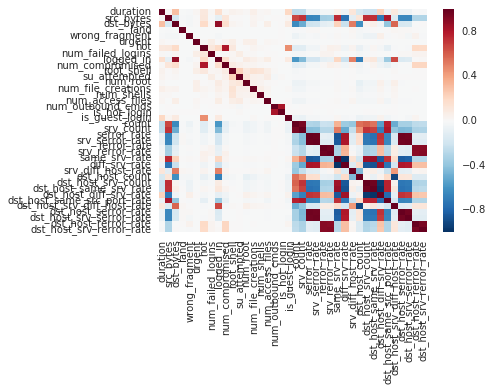

In [29]:
sns.heatmap(corr_df)
plt.show()

In [30]:
# get a boolean dataframe where true means that a pair of variables is
# highly correlated
highly_correlated_df = (abs(corr_df) > .8) & (corr_df < 1.0)

In [31]:
# Get the names of the variables so we use them to slice the dataframe
correlated_vars_index = (highly_correlated_df==True).any()
correlated_var_names = correlated_vars_index[correlated_vars_index==True].index

In [32]:
# Slice it
highly_correlated_df.loc[correlated_var_names, correlated_var_names]

,src_bytes,dst_bytes,hot,logged_in,num_compromised,num_outbound_cmds,is_hot_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
src_bytes,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
dst_bytes,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
hot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
logged_in,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
num_compromised,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
num_outbound_cmds,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
is_hot_login,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
count,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
srv_count,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
serror_rate,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,True,True,False,False


In [33]:
highly_correlated_df.to_csv("highly_correlated.csv", sep=",")

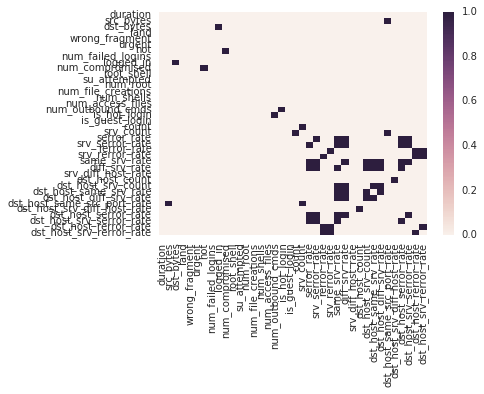

In [34]:
sns.heatmap(highly_correlated_df)
plt.show()

# Conclusions and possible model selection hints

The previous dataframe showed us which variables are highly correlated. We have kept just those variables with at least one strong correlation. We can use as we please, but a good way could be to do some model selection. That is, if we have a group of variables that are highly correlated, we can keep just one of them to represent the group under the assumption that they convey similar information as predictors. Reducing the number of variables will not improve our model accuracy, but it will make it easier to understand and also more efficient to compute.


For example, from the description of the KDD Cup 99 task we know that the variable dst_host_same_src_port_rate references the percentage of the last 100 connections to the same port, for the same destination host. In our correlation matrix (and auxiliar dataframes) we find that this one is highly and positively correlated to src_bytes and srv_count. The former is the number of bytes sent form source to destination. The later is the number of connections to the same service as the current connection in the past 2 seconds. We might decide not to include dst_host_same_src_port_rate in our model if we include the other two, as a way to reduce the number of variables and later one better interpret our models.